# Preprocessing and More EDA

In [3]:
import pandas as pd
import numpy as np
import sktime
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

In [4]:
#investigating Campus 5
df = pd.read_csv('../../data/cleaned/campus5.csv', index_col='Timestamp')
df.index = pd.to_datetime(df.index)

In [5]:
df.index[0]

Timestamp('2020-01-01 00:15:00')

In [6]:
df.index[-1]

Timestamp('2022-04-23 23:45:00')

In [7]:
df.index[-1] - df.index[0]

Timedelta('843 days 23:30:00')

In [8]:
# Only examining Solar Generation in these models
df = df[['SolarGeneration']]

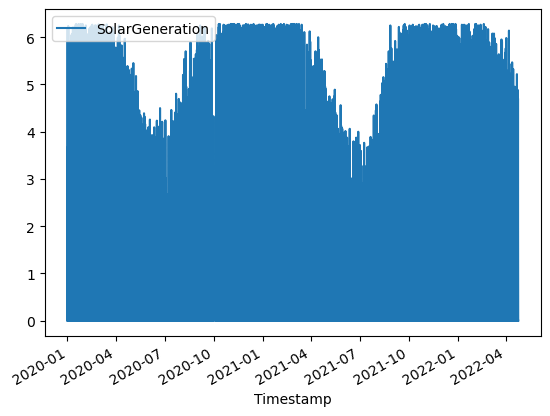

In [9]:
df.plot();

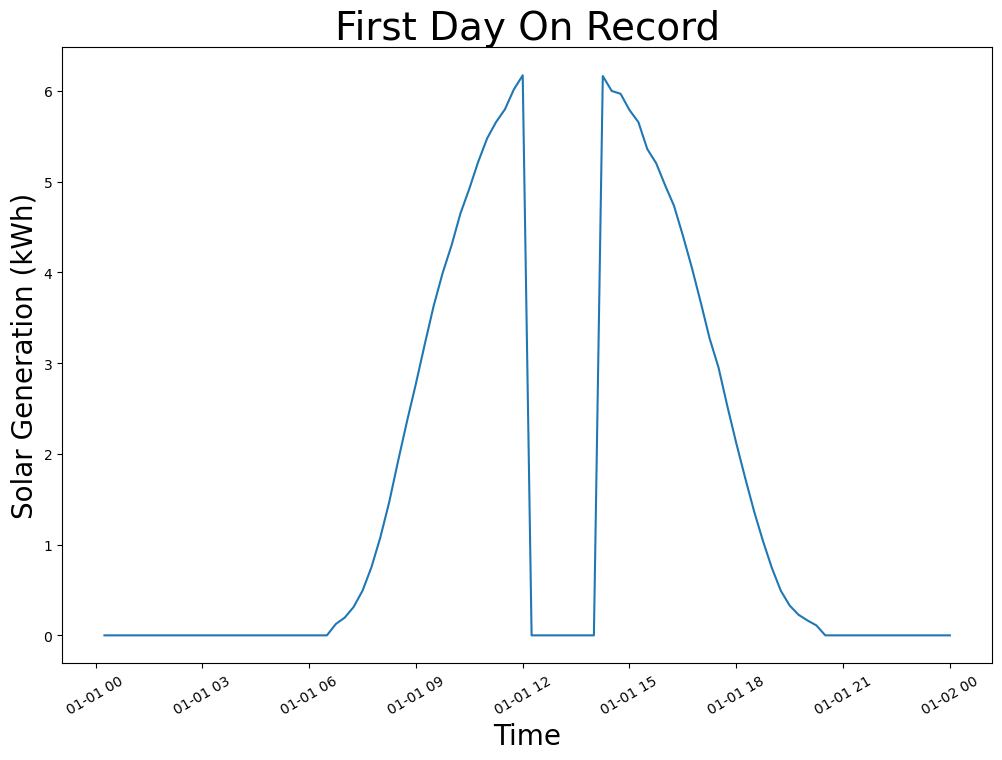

In [33]:
#The first day on record
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(df[:96])
ax.set_xlabel('Time', fontsize = 20)
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_ylabel('Solar Generation (kWh)', fontsize = 20)
ax.set_title('First Day On Record', fontsize = 28);
plt.savefig('../../images/Campus5_firstday.png')

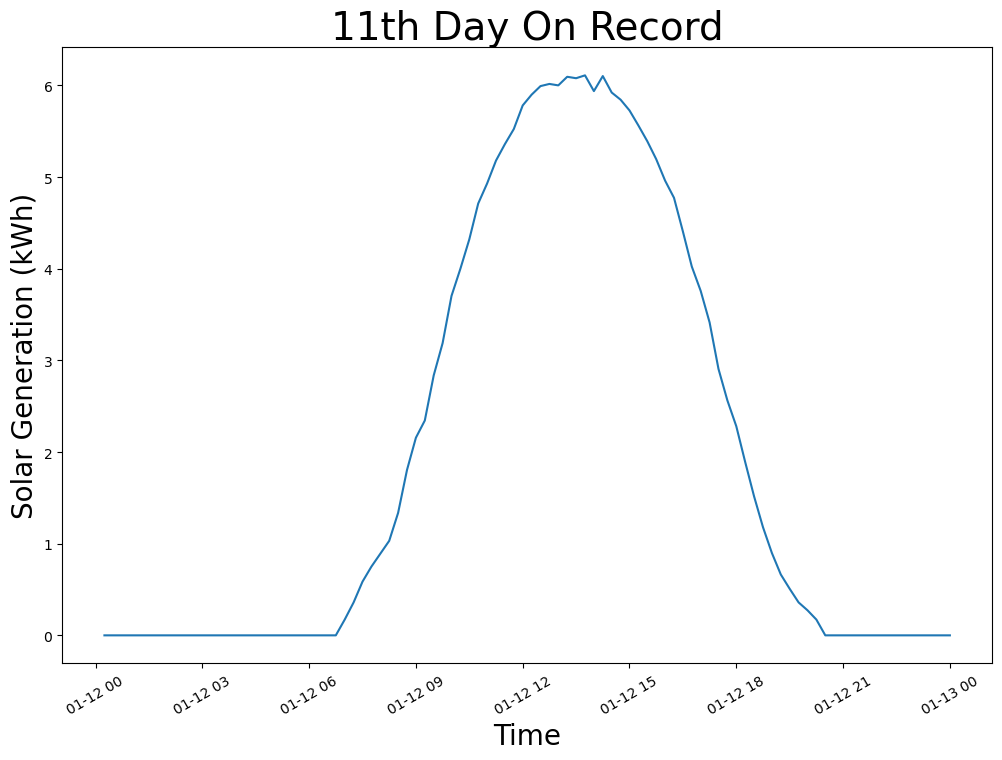

In [34]:
# The 11th day on record
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(df[1056:1152])
ax.set_xlabel('Time', fontsize = 20)
for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_ylabel('Solar Generation (kWh)', fontsize = 20)
ax.set_title('11th Day On Record', fontsize = 28);
plt.savefig('../../images/Campus5_eleventhday.png')

The two above daily plots show the variability in the generation output for each day

> This variability could arise from weather, shade, or electrical/component malfunction

In [12]:
#train/test splitting
y_train, y_test = temporal_train_test_split(df, test_size=0.15)

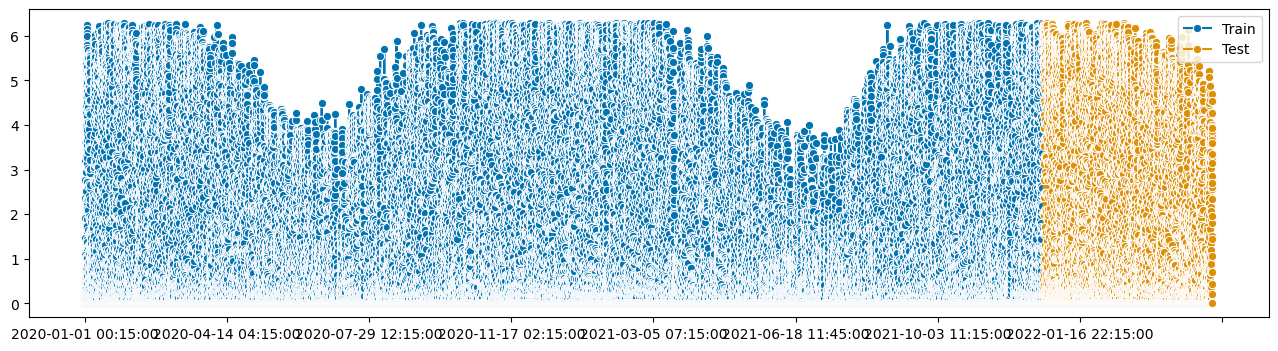

In [35]:
plot_series(y_train, y_test, labels = ['Train', 'Test']);

Naive Forecaster will be baseline:

In [14]:
y_train.values[-1][0]

0.0

In [15]:
# Using the last value of y_train for the baseline predictions (Naive Forecaster had difficulty
    #with thte frequency of the data's index)
baseline = y_train.values[-1][0]
baseline_preds = pd.Series(index = y_test.index, data = baseline)

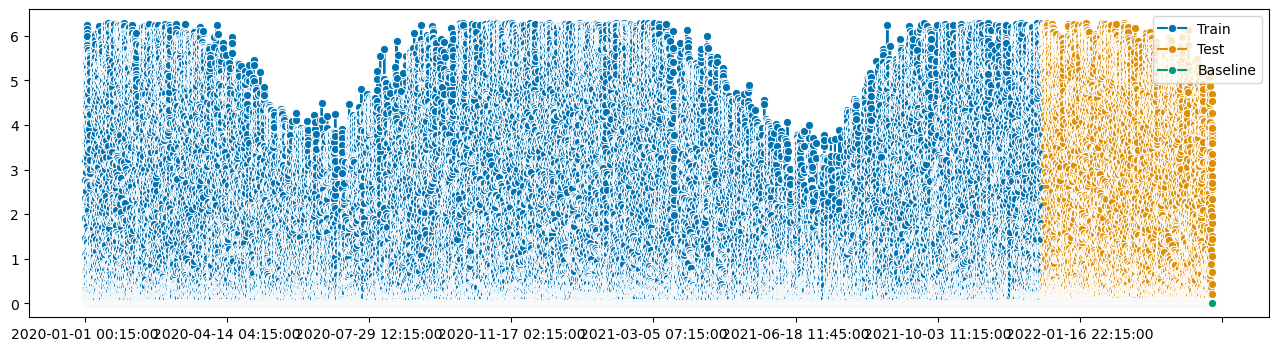

In [16]:
#The green dot in the far right bottom corner is the horizontal line of baseline predictions
plot_series(y_train, y_test, baseline_preds, labels = ['Train', 'Test', 'Baseline']);

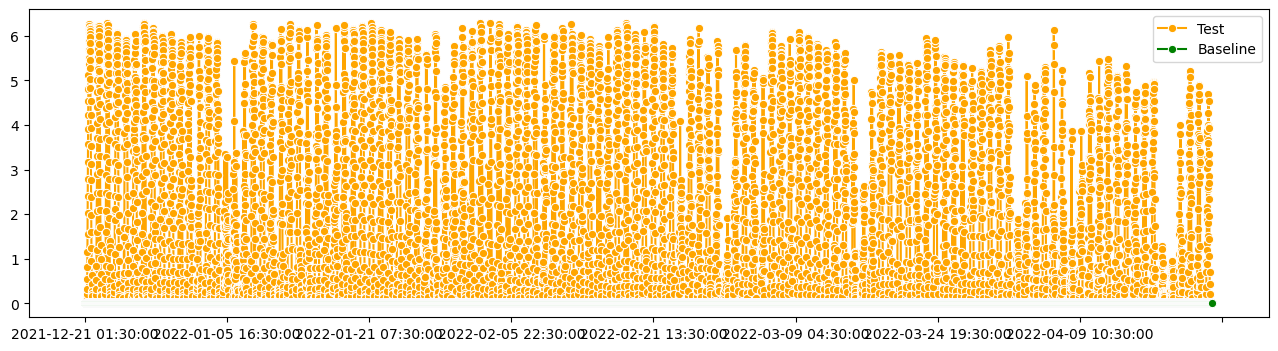

In [17]:
#The green dot in the far right bottom corner is the horizontal line of baseline predictions
plot_series(y_test, baseline_preds, labels = ['Test', 'Baseline'], colors = ['orange', 'green']);

In [18]:
mean_squared_error(y_test.values, baseline_preds.values, squared = False)

2.447305084289423

In [19]:
mean_absolute_error(y_test.values, baseline_preds.values)

1.4105942175155488

---
## Hourly Investigation
---

In [20]:
hourly = df['SolarGeneration'].resample('H').mean().ffill()

<AxesSubplot: xlabel='Timestamp'>

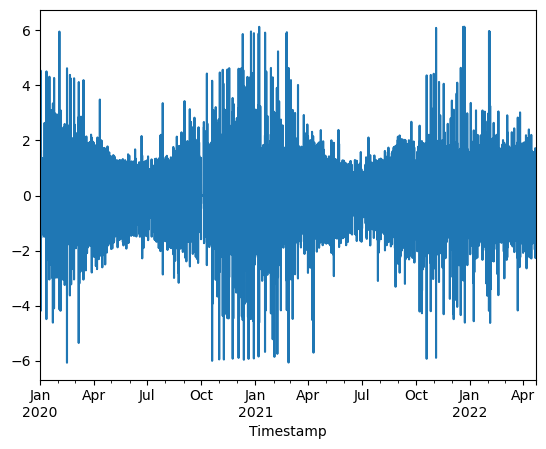

In [21]:
hourly.diff().plot()

<AxesSubplot: xlabel='Timestamp'>

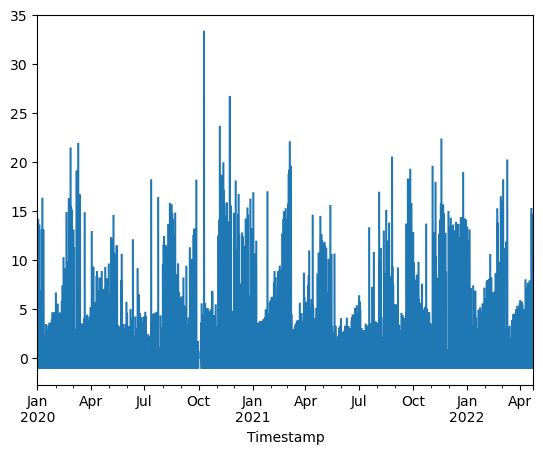

In [22]:
hourly.pct_change().plot()

In [23]:
hourly.pct_change().describe()

count    1.071800e+04
mean              inf
std               NaN
min     -1.000000e+00
25%     -4.725583e-01
50%      1.038813e-02
75%      8.712822e-01
max               inf
Name: SolarGeneration, dtype: float64

The many values near 0, as well as the extreme change that can happen in generation (shown in the two extremely varied daily generation outputs above) cause the pct_change to have interestesting properties such as 'inf' values.

---
### Investigating Augmented Dickey Fuller Test to determine stationarity

In [24]:
def interpret_dftest(dftest):
    '''
    Pre-written () function for better readability for the dftest results.
    '''
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [25]:
#Investigating hourly
interpret_dftest(adfuller(hourly))

Test Statistic   -1.021377e+01
p-value           5.550218e-18
dtype: float64

In [26]:
#Investigating hourly with one difference
interpret_dftest(adfuller(hourly.diff().dropna()))

Test Statistic   -36.93214
p-value            0.00000
dtype: float64

---
The Augmented Dickey-Fuller Test shows that the hourly resampled data is stationary. So for ARIMA models, the d parameter will equal 0.  (p-value below 0.005)

---

In [27]:
# Investigating the 15-min frequency data:
interpret_dftest(adfuller(df))

Test Statistic   -48.987777
p-value            0.000000
dtype: float64

This shows the original data is stationary as well. (p-value below 0.005)